In [ ]:
from pathlib import Path

import numpy as np
import polars.selectors as cs

import polars as pl
import pandas as pd

import anndata as ad
import scanpy as sc
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap 

from ngio import open_ome_zarr_plate, open_ome_zarr_container
from ngio.hcs._plate import concatenate_image_tables_as
from ngio.hcs._plate import _build_extras
from ngio.tables.v1 import FeatureTableV1

import matplotlib.pyplot as plt
import seaborn as sns
import napari

from fractal_paper_2026.multiplex3d_abbott.utils import (
    unnest_all_structs,
    to_tall
)

# Cannot import for dependency conflicts with ngio=0.4.6 requires ngio=0.5.2
# https://github.com/pelkmanslab/abbott-features
# from abbott_features.intensity_normalization.polars_selector import sel


In [2]:
# Set Parameters

row = "B"
column = "02"
label = 4
ref_cycle = 1

features = sel.label | sel.intensity | sel.density | sel.correlation | sel.distance

fld = Path("/Volumes/active/rhornb/fractal_paper/data/AssayPlate_Greiner_CELLSTAR655090.zarr")
ome_plate = open_ome_zarr_plate(fld)

In [ ]:
# Load labelled nuclei

well = f"{row}/{column}"
ome_zarr = ome_plate.get_image(row=row, column=column, image_path=str(ref_cycle))

roi_table = ome_zarr.get_table("embryo_ROI_table")
roi = [r for r in roi_table.rois() if r.name == str(label)][0]

lbls = ome_zarr.get_masked_label("nuclei", "embryo", "embryo_ROI_table", path=str(ref_cycle))
lbl = lbls.get_roi(label)

In [ ]:
# Load feature tables
ome_zarr_well = ome_plate.get_well(row=row, column=column)
img_paths = [f"{row}/{column}/{img_path}" for img_path in ome_zarr_well.paths()]

images = [open_ome_zarr_container(fld/img_path) for img_path in img_paths]

nuc_feature_table_name = "nuclei_z_corrected"
cell_feature_table_name = "cells_z_corrected"

# Load tables
df_features_pd_nuc = concatenate_image_tables_as(
    images=images,
    extras=_build_extras(img_paths),
    table_cls=FeatureTableV1,
    name=nuc_feature_table_name,
    index_key="index",
)

df_features_pd_cells = concatenate_image_tables_as(
    images=images,
    extras=_build_extras(img_paths),
    table_cls=FeatureTableV1,
    name=cell_feature_table_name,
    index_key="index",
)

# Process tables
df_features_nuc = pl.from_pandas(
    df_features_pd_nuc.dataframe, include_index=True
)
df_features_nuc = df_features_nuc.with_columns(
    pl.concat_str(["label", "ROI"], separator="_").alias("index")
)
df_features_nuc = df_features_nuc.filter(pl.col("ROI") == str(label))

df_features_cell = pl.from_pandas(
    df_features_pd_cells.dataframe, include_index=True
)
df_features_cell = df_features_cell.with_columns(
    pl.concat_str(["label", "ROI"], separator="_").alias("index")
)
df_features_cell = df_features_cell.filter(pl.col("ROI") == str(label))

df_features_nuc = to_tall(df_features_nuc, index_key="index")
df_features_nuc = df_features_nuc.with_columns(
    pl.col("parent.cells").cast(pl.Int32),
    pl.col("parent.embryo").cast(pl.Int32),
)

df_features_cell = to_tall(df_features_cell, index_key="index").drop("index")

# Merge and unnest
df = df_features_nuc.join(df_features_cell, 
                        left_on=["parent.cells", "parent.embryo", "ROI", "row", "column", "path_in_well"], 
                        right_on=["label", "parent.embryo", "ROI", "row", "column", "path_in_well"], how="inner")

df = unnest_all_structs(df)

# Load annotations table
annotations_table = ome_zarr.get_table("annotations_table").dataframe
annotations_table = pl.from_pandas(annotations_table, include_index=True)
annotations_table = annotations_table.with_columns(
    pl.col("ROI").cast(str), 
    pl.col("label").cast(pl.Int32),
    pl.col("celltype_annotation").cast(pl.Categorical),)

# Join features with annotations
df = df.join(annotations_table, on = ["label", "ROI"])
df

In [ ]:
# Filter features
df_filtered = df.drop(sel.correlation, cs.matches("Kurtosis"), cs.matches("-"), 
                      cs.matches(r"\."), cs.matches("PerimeterOnBorder"),
                      "row", "column", cs.matches("DAPI"), "celltype_annotation"
)
df_filtered

index,label,ROI,FLAG_Maximum,FLAG_Mean,FLAG_Median,FLAG_Minimum,FLAG_Skewness,FLAG_StandardDeviation,FLAG_Sum,FLAG_Variance,FLAG_WeightedElongation,FLAG_WeightedFlatness,PCNA_Maximum,PCNA_Mean,PCNA_Median,PCNA_Minimum,PCNA_Skewness,PCNA_StandardDeviation,PCNA_Sum,PCNA_Variance,PCNA_WeightedElongation,PCNA_WeightedFlatness,path_in_well,Elongation,EquivalentSphericalPerimeter,EquivalentSphericalRadius,Flatness,Perimeter,PhysicalSize,Roundness,H3K27Ac_Maximum,H3K27Ac_Mean,H3K27Ac_Median,H3K27Ac_Minimum,H3K27Ac_Skewness,H3K27Ac_StandardDeviation,…,YAP_Maximum,YAP_Mean,YAP_Median,YAP_Minimum,YAP_Skewness,YAP_StandardDeviation,YAP_Sum,YAP_Variance,YAP_WeightedElongation,YAP_WeightedFlatness,XRN2_Maximum,XRN2_Mean,XRN2_Median,XRN2_Minimum,XRN2_Skewness,XRN2_StandardDeviation,XRN2_Sum,XRN2_Variance,XRN2_WeightedElongation,XRN2_WeightedFlatness,Elongation_right,EquivalentSphericalPerimeter_right,EquivalentSphericalRadius_right,Flatness_right,Perimeter_right,PhysicalSize_right,Roundness_right,bCatenin_Maximum,bCatenin_Mean,bCatenin_Median,bCatenin_Minimum,bCatenin_Skewness,bCatenin_StandardDeviation,bCatenin_Sum,bCatenin_Variance,bCatenin_WeightedElongation,bCatenin_WeightedFlatness
str,i32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1_4""",1,"""4""",225.5826,43.985402,77.343903,4.176766,1.593047,15.045362,436335.189763,226.36293,1.548478,1.199226,140.759888,79.074945,60.591602,27.039115,0.015027,14.211887,784423.450944,201.977729,1.568186,1.205632,"""0""",1.611295,498.887996,6.300813,1.192062,542.36909,1047.8,0.919831,532.891218,222.094319,463.523193,58.430005,0.702882,69.877724,…,190.688406,106.871385,380.383362,35.257781,-0.008392,23.21763,1.0602e6,539.058362,1.510429,1.24888,250.550215,148.667414,175.10965,58.34225,-0.14436,26.24897,1.4748e6,689.008401,1.537851,1.227859,1.307703,1806.39399,11.989507,1.183502,3683.641273,7219.2575,0.490383,593.986733,116.470409,280.105103,14.413949,1.772842,45.001784,7.9605e6,2025.160562,1.230638,1.256114
"""2_4""",2,"""4""",166.070825,45.331686,77.343903,3.173478,1.415031,16.495137,225933.121847,272.089548,1.664,1.12116,288.433464,115.483924,100.986004,40.01658,0.962559,37.736404,575571.877534,1424.036198,1.718693,1.122679,"""0""",1.719473,315.292733,5.009012,1.091535,347.513209,526.435,0.907283,422.102646,184.429679,463.523193,44.14643,0.439896,54.920989,…,176.503489,108.738371,380.383362,31.393615,-0.272346,21.117748,541952.04197,445.959266,1.664286,1.099284,218.25855,150.029849,175.10965,58.187677,-0.394767,25.20223,747748.768924,635.152422,1.691793,1.085211,1.324301,1323.252338,10.261631,1.757086,2996.652731,4526.2425,0.441577,439.986383,113.556528,280.105103,15.613944,1.373832,37.730874,4.8661e6,1423.618869,1.303413,1.723192
"""3_4""",3,"""4""",184.044319,75.709115,77.343903,13.811333,0.575747,29.644934,767084.754093,878.822138,1.417771,1.069914,1060.980128,470.071724,464.535614,59.193435,0.262619,247.174655,4.7628e6,61095.309833,1.371792,1.07337,"""0""",1.3807,505.970729,6.345382,1.080538,545.872635,1070.1925,0.926903,320.527143,181.60647,463.523193,53.474448,-0.118142,43.272711,…,208.855524,106.295199,380.383362,36.625884,0.567151,26.160664,1.0770e6,684.380355,1.409137,1.039318,264.606982,161.433003,175.10965,71.573597,0.372873,30.403332,1.6356e6,924.362603,1.407808,1.050479,1.150563,2352.585841,13.682574,1.534018,5805.832644,10729.81,0.405211,442.248686,106.922465,280.105103,15.556881,1.370406,36.541475,1.0862e7,1335.279411,1.165269,1.493394
"""4_4""",4,"""4""",228.341076,88.808882,77.343903,7.404782,0.584178,40.059177,1.2280e6,1604.737635,1.224608,1.045154,1096.670591,512.486702,504.930008,54.353341,0.143068,267.078638,7.0867e6,71330.999044,1.186567,1.04377,"""0""",1.207042,622.541326,7.038485,1.093057,676.86561,1460.5825,0.919741,338.572397,188.

In [126]:
# Remove highly correlated feature columns

# Compute correlation matrix on non-selected features
feature_matrix = df_filtered.drop(sel.index).to_numpy()
corr_matrix = np.corrcoef(feature_matrix, rowvar=False)

threshold = 0.9
to_remove = set()
n_features = corr_matrix.shape[0]

# Identify highly correlated feature indices
for i in range(n_features):
    for j in range(i + 1, n_features):
        if abs(corr_matrix[i, j]) > threshold:
            to_remove.add(j)

# Keep only uncorrelated features
kept_columns = [
    col
    for idx, col in enumerate(df_filtered.columns)
    if idx not in to_remove
]

# Reattach selected columns
df_reduced = (
    df_filtered
    .select(kept_columns)
    .with_columns(df_filtered.select(sel.index))
)

df_reduced


/Users/ruthh/Pelkmans/Git/fractal-abbott-analysis-2026/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ruthh/Pelkmans/Git/fractal-abbott-analysis-2026/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


index,label,ROI,FLAG_Maximum,FLAG_Mean,FLAG_StandardDeviation,FLAG_Sum,FLAG_Variance,PCNA_Maximum,PCNA_Mean,PCNA_Minimum,PCNA_WeightedElongation,EquivalentSphericalRadius,Flatness,Perimeter,PhysicalSize,Roundness,H3K27Ac_Maximum,H3K27Ac_Mean,H3K27Ac_Minimum,H3K27Ac_Sum,H3K27Ac_Variance,H3K27Ac_WeightedFlatness,pH3_Maximum,pH3_Median,pH3_Sum,pH3_WeightedFlatness,embryo_MinimumDistanceToBorder,embryo_CentroidDistanceAlongZ,embryo_MaximumDistanceAlongZ,RAD:100_Count,RAD:200_Count,KNNd:100_Mean,KNNd:100_Max,KNNd:200_Mean,KNNd:200_Max,DELAUNAY:1_Count,TOUCH:1_Count,H2B_Maximum,H2B_Mean,H2B_Sum,H2B_Variance,H2B_WeightedElongation,H2B_WeightedFlatness,ALYREF_Maximum,ALYREF_Mean,ALYREF_Sum,ALYREF_Variance,ALYREF_WeightedElongation,ALYREF_WeightedFlatness,Nanog_Maximum,Nanog_Variance,Nanog_WeightedElongation,Nanog_WeightedFlatness,YAP_Maximum,YAP_Sum,YAP_Variance,YAP_WeightedElongation,YAP_WeightedFlatness,XRN2_Maximum,XRN2_Sum,XRN2_Variance,XRN2_WeightedFlatness,Elongation_right,EquivalentSphericalRadius_right,Flatness_right,Perimeter_right,Roundness_right,bCatenin_Maximum,bCatenin_Median,bCatenin_Sum,bCatenin_Variance,bCatenin_WeightedElongation,bCatenin_WeightedFlatness,path_in_well
str,i32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""1_4""",1,"""4""",225.5826,43.985402,15.045362,436335.189763,226.36293,140.759888,79.074945,27.039115,1.568186,6.300813,1.192062,542.36909,1047.8,0.919831,532.891218,222.094319,58.430005,2.2032e6,4882.896312,1.218328,502.936629,229.948151,2.6943e6,1.237733,0.0,11.0,23.0,345.0,1766.0,48.595291,64.665628,61.517423,82.159264,16.0,0.0,824.016641,360.448106,3.5756e6,19404.421304,1.616408,1.194033,364.925094,219.137442,2.1738e6,2101.7435,1.493289,1.247073,200.957132,556.65498,1.524055,1.235544,190.688406,1.0602e6,539.058362,1.510429,1.24888,250.550215,1.4748e6,689.008401,1.227859,1.307703,11.989507,1.183502,3683.641273,0.490383,593.986733,280.105103,7.9605e6,2025.160562,1.230638,1.256114,"""0"""
"""2_4""",2,"""4""",166.070825,45.331686,16.495137,225933.121847,272.089548,288.433464,115.483924,40.01658,1.718693,5.009012,1.091535,347.513209,526.435,0.907283,422.102646,184.429679,44.14643,919197.519895,3016.31501,1.103594,313.547129,229.948151,971988.817212,1.092616,0.0,9.0,17.0,384.0,1853.0,44.719467,61.348697,57.36853,78.187047,14.0,1.0,611.892659,310.81362,1.5491e6,10046.653879,1.66443,1.134806,300.055668,180.087437,897555.788329,2222.810293,1.648571,1.08678,202.338516,598.458109,1.688472,1.091432,176.503489,541952.04197,445.959266,1.664286,1.099284,218.25855,747748.768924,635.152422,1.085211,1.324301,10.261631,1.757086,2996.652731,0.441577,439.986383,280.105103,4.8661e6,1423.618869,1.303413,1.723192,"""0"""
"""3_4""",3,"""4""",184.044319,75.709115,29.644934,767084.754093,878.822138,1060.980128,470.071724,59.193435,1.371792,6.345382,1.080538,545.872635,1070.1925,0.926903,320.527143,181.60647,53.474448,1.8400e6,1872.527541,1.055649,389.905943,229.948151,2.1708e6,1.048153,0.0,9.0,18.0,377.0,1830.0,46.054197,61.677289,58.933247,79.137373,13.0,0.0,515.222117,297.336778,3.0126e6,4619.950861,1.340442,1.087764,685.210045,285.857573,2.8963e6,10097.704522,1.434105,1.036133,302.859535,2109.585696,1.414269,1.055618,208.855524,1.0770e6,684.380355,1.409137,1.039318,264.606982,1.6356e6,924.362603,1.050479,1.150563,13.682574,1.534018,5805.832644,0.405211,442.248686,280.105103,1.0862e7,1335.279411,1.165269,1.493394,"""0"""
"""4_4""",4,"""4""",228.341076,88.808882,40.059177,1.2280e6,1604.737635,1096.670591,512.486702,54.353341,1.186567,7.038485,1.093057,676.86561,1460.5825,0.919741,338.572397,188.862457,55.615498,2.6116e6,2315.491032,1.099294,439.901942,229.948151,3.2606e6,1.118793,0.0,8.0,20.0,392.0,1749.0,44.476436,58.755171,56.576359,76.745077,15.0,1.0,519.189619,310.422455,4.29

In [127]:
# Determine number of PCA components to explain 90% variance 

X = df_reduced.drop(sel.index).to_numpy()

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(svd_solver="full")
pca.fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.searchsorted(cumulative_variance, 0.9) + 1

print(num_components)

# Get dataframe with num_components principal components
X_pca = pca.transform(X_scaled)[:, :num_components]
df_pca = pl.DataFrame(X_pca, schema=[f"PC{i+1}" for i in range(num_components)])
df_pca = df_pca.with_columns(df_reduced.select(sel.index))
df_pca

16


PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,index,label,ROI,path_in_well
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,str,str
-0.582895,-0.162547,1.18977,-2.405624,-0.191598,0.078617,-2.386409,0.468275,-0.605124,0.514636,1.655847,-0.549885,-0.254532,0.610927,-0.279794,2.49816,"""1_4""",1,"""4""","""0"""
-2.737241,1.085891,-1.219566,-2.682998,0.094001,-2.378985,-2.280123,1.342132,0.012993,0.703414,0.451911,-1.39318,-0.129284,-0.065401,1.788549,2.24966,"""2_4""",2,"""4""","""0"""
0.87936,2.135805,0.012739,-4.295467,0.083514,-0.456695,-1.358557,0.44388,-0.458301,0.311498,0.828508,-1.081445,-0.115682,-0.08359,0.666164,2.274236,"""3_4""",3,"""4""","""0"""
0.351803,7.780687,2.923522,-9.938343,0.190146,10.035353,-0.291168,-1.959537,-4.709748,0.010568,2.54044,-5.970874,0.378263,0.051066,12.703879,7.674718,"""4_4""",4,"""4""","""0"""
3.937975,1.233828,0.895182,-2.970101,-0.050382,-0.240313,-1.834515,0.428782,-0.244245,0.049453,0.405367,-0.580306,-0.289667,-0.57149,-0.656237,1.922672,"""5_4""",5,"""4""","""0"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-3.191177,7.436008,2.29775,-0.494261,-0.279963,5.009105,-0.039607,-3.154382,-0.042464,5.28725,0.432486,1.638769,1.381218,0.647828,2.624548,-0.312929,"""2899_4""",2899,"""4""","""0"""
-4.744207,7.95196,0.327366,3.63253,0.267813,2.128843,-1.401155,-2.133019,0.717627,6.203017,-1.733782,1.43391,1.332075,-0.359032,2.814618,-2.409899,"""2900_4""",2900,"""4""","""0"""
-7.328566,7.714618,0.269312,4.40668,0.666603,2.800272,-1.904586,-1.757129,-0.058517,3.102044,-1.189655,0.446437,1.102775,0.298096,1.228019,-1.325788,"""2901_4""",2901,"""4""","""0"""


In [ ]:
# Run Leiden clustering with feature + spatially informed graph

df_norm_values = df_pca.drop(df_pca.select(sel.index).columns)
adata = ad.AnnData(X=df_norm_values.to_pandas())

# Get coordinates
df_coords = df.select(["Centroid.x", "Centroid.y", "Centroid.z"])
coords = np.array(list(df_coords.select(["Centroid.x", "Centroid.y", "Centroid.z"]).iter_rows()))
adata.obsm['spatial'] = coords

# Add embryo information
embryo_ids = df_reduced.select("ROI").to_series().to_list()
adata.obs['embryo'] = embryo_ids

## Construct spatial nearest neighbor graph
# Number of neighbors to consider
n_neighbors = 5
nn = NearestNeighbors(n_neighbors=n_neighbors + 1, radius=5) 
nn.fit(coords)
distances, indices = nn.kneighbors(coords)

n_cells = adata.n_obs
rows = np.repeat(np.arange(n_cells), n_neighbors)
cols = indices[:, 1:].flatten()  # skip self (index 0)
data = np.ones(len(rows), dtype=np.float32)

# Create sparse connectivity matrix
nn_graph_space = sparse.csr_matrix((data, (rows, cols)), shape=(n_cells, n_cells))

# Make symmetric (undirected graph)
nn_graph_space = nn_graph_space + nn_graph_space.T
nn_graph_space[nn_graph_space > 1] = 1

# Mask connections across different embryos
embryo_codes = pd.Categorical(adata.obs['embryo']).codes
different_embryo_mask = embryo_codes[:, None] != embryo_codes[None, :]
nn_graph_space = nn_graph_space.tolil()
nn_graph_space[different_embryo_mask] = 0
nn_graph_space = nn_graph_space.tocsr()

## Construct nearest neighbor graph based on features
sc.pp.neighbors(adata, metric="euclidean", n_neighbors=15, use_rep='X')
nn_graph_features = adata.obsp["connectivities"]

alpha = 0.1
joint_graph = (1 - alpha) * nn_graph_features + alpha * nn_graph_space


/Users/ruthh/Pelkmans/Git/fractal-abbott-analysis-2026/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
# Run Leiden clustering on the joint graph

sc.tl.leiden(adata, resolution=0.3, adjacency = joint_graph, key_added="squidpy_domains", random_state=42)

labels = adata.obs['squidpy_domains'].astype('int32').to_numpy()
len(np.unique(labels))

6

In [ ]:
# Add cluster labels to dataframe

df_clustered = df_pca.with_columns(
    pl.Series(name="clusters", values=labels)
)
df_clustered

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,index,label,ROI,path_in_well,clusters
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,str,str,i32
-0.582895,-0.162547,1.18977,-2.405624,-0.191598,0.078617,-2.386409,0.468275,-0.605124,0.514636,1.655847,-0.549885,-0.254532,0.610927,-0.279794,2.49816,"""1_4""",1,"""4""","""0""",4
-2.737241,1.085891,-1.219566,-2.682998,0.094001,-2.378985,-2.280123,1.342132,0.012993,0.703414,0.451911,-1.39318,-0.129284,-0.065401,1.788549,2.24966,"""2_4""",2,"""4""","""0""",1
0.87936,2.135805,0.012739,-4.295467,0.083514,-0.456695,-1.358557,0.44388,-0.458301,0.311498,0.828508,-1.081445,-0.115682,-0.08359,0.666164,2.274236,"""3_4""",3,"""4""","""0""",3
0.351803,7.780687,2.923522,-9.938343,0.190146,10.035353,-0.291168,-1.959537,-4.709748,0.010568,2.54044,-5.970874,0.378263,0.051066,12.703879,7.674718,"""4_4""",4,"""4""","""0""",5
3.937975,1.233828,0.895182,-2.970101,-0.050382,-0.240313,-1.834515,0.428782,-0.244245,0.049453,0.405367,-0.580306,-0.289667,-0.57149,-0.656237,1.922672,"""5_4""",5,"""4""","""0""",3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-3.191177,7.436008,2.29775,-0.494261,-0.279963,5.009105,-0.039607,-3.154382,-0.042464,5.28725,0.432486,1.638769,1.381218,0.647828,2.624548,-0.312929,"""2899_4""",2899,"""4""","""0""",5
-4.744207,7.95196,0.327366,3.63253,0.267813,2.128843,-1.401155,-2.133019,0.717627,6.203017,-1.733782,1.43391,1.332075,-0.359032,2.814618,-2.409899,"""2900_4""",2900,"""4""","""0""",5
-7.328566,7.714618,0.269312,4.40668,0.666603,2.800272,-1.904586,-1.757129,-0.058517,3.102044,-1.189655,0.446437,1.102775,0.298096,1.228019,-1.325788,"""2901_4""",2901,"""4""","""0""",5


In [128]:
# Plot UMAP 

# Select only numeric feature columns
feature_columns = [col for col in df_clustered.columns if col not in ["label", "clusters", "index", "path_in_well", "ROI"]]

# Compute embedding
umap_model = umap.UMAP(
    random_state=42,
)
embedding = umap_model.fit_transform(df_clustered.select(feature_columns).to_numpy())

/Users/ruthh/Pelkmans/Git/fractal-abbott-analysis-2026/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Map clusters to annotation names

clusters_merge_dict = {
    "DC 1": [0],
    "DC 2": [1],
    "DC 3": [2],
    "EVL": [3],
    "DC 4": [4],
    "YSL": [5],
}

df_clustered_merged = df_clustered.with_columns(
    pl.col("clusters").map_elements(
        lambda x: next(
            (new_label for new_label, old_labels in clusters_merge_dict.items() if x in old_labels),
            "Other"
        )
    ).alias("clusters_merged")
)

df_clustered_merged

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,index,label,ROI,path_in_well,clusters,clusters_merged
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,str,str,i32,str
-0.582895,-0.162547,1.18977,-2.405624,-0.191598,0.078617,-2.386409,0.468275,-0.605124,0.514636,1.655847,-0.549885,-0.254532,0.610927,-0.279794,2.49816,"""1_4""",1,"""4""","""0""",4,"""DC 4"""
-2.737241,1.085891,-1.219566,-2.682998,0.094001,-2.378985,-2.280123,1.342132,0.012993,0.703414,0.451911,-1.39318,-0.129284,-0.065401,1.788549,2.24966,"""2_4""",2,"""4""","""0""",1,"""DC 2"""
0.87936,2.135805,0.012739,-4.295467,0.083514,-0.456695,-1.358557,0.44388,-0.458301,0.311498,0.828508,-1.081445,-0.115682,-0.08359,0.666164,2.274236,"""3_4""",3,"""4""","""0""",3,"""EVL"""
0.351803,7.780687,2.923522,-9.938343,0.190146,10.035353,-0.291168,-1.959537,-4.709748,0.010568,2.54044,-5.970874,0.378263,0.051066,12.703879,7.674718,"""4_4""",4,"""4""","""0""",5,"""YSL"""
3.937975,1.233828,0.895182,-2.970101,-0.050382,-0.240313,-1.834515,0.428782,-0.244245,0.049453,0.405367,-0.580306,-0.289667,-0.57149,-0.656237,1.922672,"""5_4""",5,"""4""","""0""",3,"""EVL"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-3.191177,7.436008,2.29775,-0.494261,-0.279963,5.009105,-0.039607,-3.154382,-0.042464,5.28725,0.432486,1.638769,1.381218,0.647828,2.624548,-0.312929,"""2899_4""",2899,"""4""","""0""",5,"""YSL"""
-4.744207,7.95196,0.327366,3.63253,0.267813,2.128843,-1.401155,-2.133019,0.717627,6.203017,-1.733782,1.43391,1.332075,-0.359032,2.814618,-2.409899,"""2900_4""",2900,"""4""","""0""",5,"""YSL"""
-7.328566,7.714618,0.269312,4.40668,0.666603,2.800272,-1.904586,-1.757129,-0.058517,3.102044,-1.189655,0.446437,1.102775,0.298096,1.228019,-1.325788,"""2901_4""",2901,"""4""","""0""",5,"""YSL"""


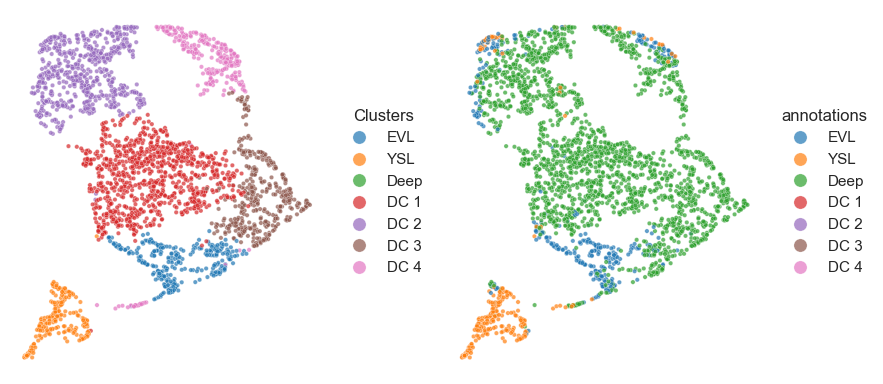

In [ ]:
# Prepare data for plotting

embedding_pl = pl.DataFrame({
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1],
    "annotations": df["celltype_annotation"],
    "clusters_merged": df_clustered_merged["clusters_merged"],
})
embedding_pd = embedding_pl.to_pandas()

cluster_to_int = {
    "EVL": 0,
    "YSL": 1,
    "Deep": 2,
    "DC 1": 3,
    "DC 2": 4,
    "DC 3": 5,
    "DC 4": 6,
}

base_colors = sns.color_palette("tab10", n_colors=len(cluster_to_int))
palette = {cluster: base_colors[idx] for cluster, idx in cluster_to_int.items()}

sns.set_theme(style="white")

fig, axes = plt.subplots(
    ncols=2,
    figsize=(9, 4),
    sharex=True,
    sharey=True,
)

# --- Plot 1: Clusters ---
sns.scatterplot(
    data=embedding_pd,
    x="UMAP1",
    y="UMAP2",
    hue="clusters_merged",
    hue_order=cluster_to_int.keys(),
    palette="tab10",
    s=10,
    alpha=0.7,
    ax=axes[0],
    legend=True,
)

axes[0].axis("off")

axes[0].legend(
    title="Clusters",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    markerscale=3
)

# --- Plot 2: Annotations ---
sns.scatterplot(
    data=embedding_pd,
    x="UMAP1",
    y="UMAP2",
    hue="annotations",
    hue_order=cluster_to_int.keys(),
    palette="tab10",
    s=10,
    alpha=0.7,
    ax=axes[1],
    legend=True,
)

axes[1].axis("off")

axes[1].legend(
    title="annotations",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    markerscale=3
)
plt.tight_layout()
# plt.savefig("umap_clustering_zfish_cycle12.png", dpi=300)
plt.show()


In [ ]:
# Plot embryo with mapped clusters

# Map each segmentation label to an integer cluster ID
clusters_dict = {
    int(label): int(cluster_to_int[cluster_name])
    for label, cluster_name
    in df_clustered_merged.select("label", "clusters_merged").iter_rows()
}

# Create RGBA colormap (label ID → color)
tab10 = plt.get_cmap("tab10")
cluster_color_dict = {
    label: tab10(cluster_id)
    for label, cluster_id in clusters_dict.items()
}

# Background label transparent
cluster_color_dict[0] = (0, 0, 0, 0)

# Open Napari
viewer = napari.Viewer(ndisplay=3)
viewer.add_labels(
    lbl,
    colormap=cluster_color_dict,
    blending="minimum",
    iso_gradient_mode="smooth",
    scale=lbls.pixel_size.zyx,
)

# Viewer configuration
viewer.window.set_geometry(0, 53, 986, 790)
viewer.theme = "light"
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "µm"
viewer.scale_bar.font_size = 24
viewer.camera.zoom = 1.21

# Save screenshot
# viewer.screenshot("zfish_cycle12_umap_clusters.png")


/Users/ruthh/Pelkmans/Git/fractal-abbott-analysis-2026/.venv/lib/python3.11/site-packages/napari/utils/colormaps/colormap.py:455: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


In [ ]:
# Check accuracy of clustering with classifier annotations

df_clustered_merged = df_clustered_merged.select(["label", "clusters_merged"])
df_annotations = annotations_table.filter(pl.col("ROI") == str(label)).select(["label", "celltype_annotation"])
df_accuracy = df_clustered_merged.join(df_annotations, on="label")

# Combine all rows that match "DC" in clusters_merged to "Deep"
df_accuracy = df_accuracy.with_columns(
    pl.col("clusters_merged").map_elements(
        lambda x: "Deep" if x in ["DC 1", "DC 2", "DC 3", "DC 4"] else x)
)
correct = df_accuracy.filter(pl.col("clusters_merged") == pl.col("celltype_annotation")).height
total = df_accuracy.height
accuracy = correct / total
print(f"Clustering accuracy: {accuracy:.2%}")


Clustering accuracy: 87.52%
